## Mall Customer Segmentation

Use the given customer credentials to determine which customers are suitable becoming your target customer.

The data is from membership cards which provide Customer ID, age, gender, annual income, and spending score.

Spending Score is something you assign to the customer based on your defined parameters like customer behavior and purchasing data.

The dataset is from Kaggle, please refer to:
[link](https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python)

### 1. Import Libraries

In [2]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# feature engineering
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# modeling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

# evaluation metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

### 2. Data Loading

In [3]:
# load data
customer_data = pd.read_csv("Mall_Customers.csv")

# show first 5 lines
customer_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
# check total data and data type attributes
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#### Insight:
- there are 200 data with no missing values.
- we have numeric and categorical data.  
 a. Numeric: CustomerID, Age, Annual Income, Spending Score.
 b. Categorical: Gender

### 3. Data Cleaning
- reformat the column names: change to lowercase, remove (), and replace spaces between words by "_".

In [5]:
# change the column names to lower case
customer_data.columns = customer_data.columns.str.lower()

# replace "()" to ""
customer_data.columns = customer_data.columns.str.replace("(","")
customer_data.columns = customer_data.columns.str.replace(")","")

# change the spaces in column names to "_"ArithmeticError
customer_data.columns = customer_data.columns.str.replace(" ","_")


In [6]:
# check on dataframe
customer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   customerid            200 non-null    int64 
 1   gender                200 non-null    object
 2   age                   200 non-null    int64 
 3   annual_income_k$      200 non-null    int64 
 4   spending_score_1-100  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


### 4. Exploratory Data Analysis

#### a. Among The Numeric Variables

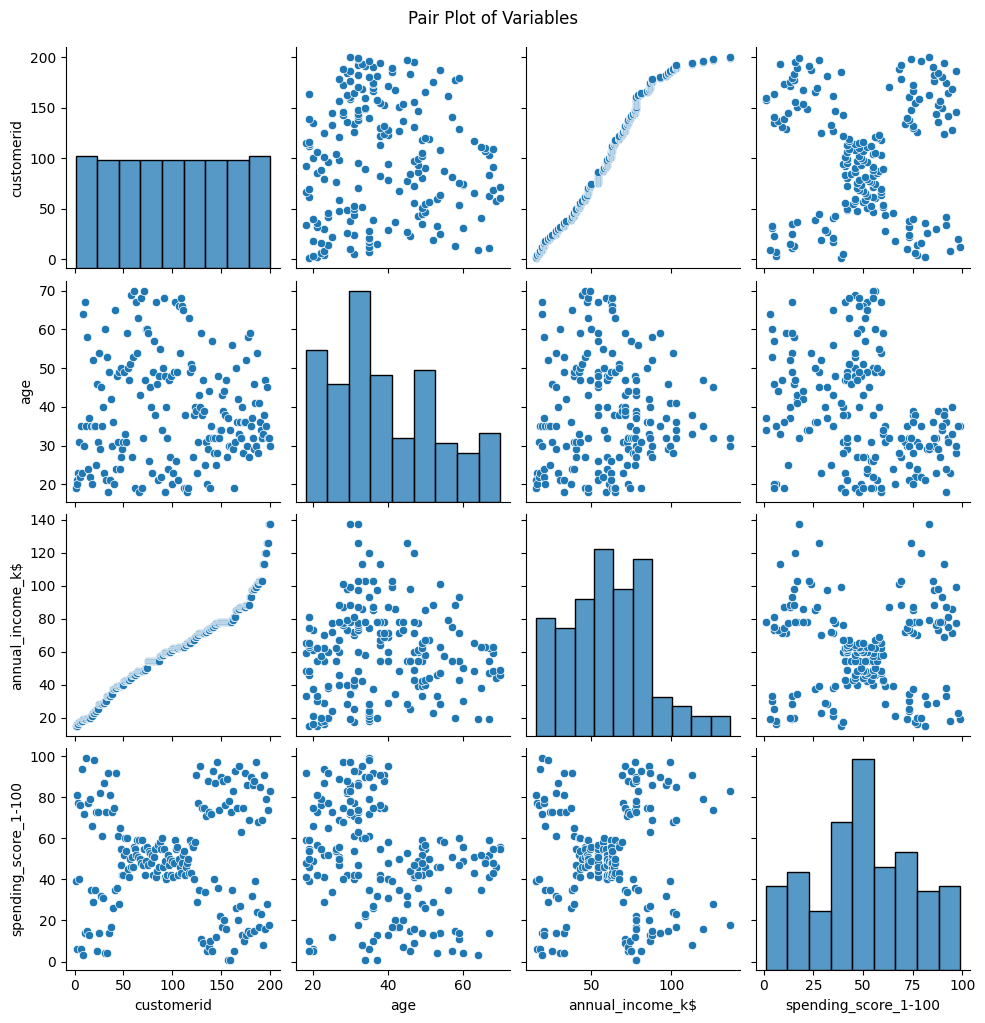

In [7]:
# make pairplot
sns.pairplot(customer_data)
plt.suptitle("Pair Plot of Variables", y=1.02)
plt.show()

#### Insight:
**Cluster formation observation**
- customerid and spending_score_1-100 as well as spending_score_1-100 and annual_income_k$ form five distinct clusters with similar positions.
- this might be possible due to different timeline when the customers were acquired.

- maybe in later times, the economic trend was growing, shown by higher customerids (more recent customers) had higher annual_income_k$. that's why the clustering patterns of customerid and annual_income_k$ with spending_score_1-100 were so similar.
 
- moreover, customerid is just an identifier so it should be still excluded from the clustering features.

**Data distribution observation**  

 With customerid removed, the remaining features have the following data distributions:
- rightly skewed: age and annual_income_k$.
- normally distributed: spending_score_1-100.
- we need to confirm with normality test.

**Age vs other numeric features**
 
Age did not seem have any clear relationship with other numeric features. We might consider to convert it into a categorical feature (age bins).

#### D'Agostino Normality Test
- it considers kurtosis for normality calculation.

 `HO`: The data has normal distribution  
 `H1`: The data has abnormal distribution

with p-value < 0.05.

In [8]:
# create normality test function
def dagostino_test(var):
    stat,p_value = stats.normaltest(var)
    print(f"Statistic: {stat}, p-value: {p_value}")
    if p_value < 0.05:
        print("The data is not normally distributed (reject H0).")
    else:
        print("The data is normally distributed (fail to reject H0).")

In [9]:
# Run the D'Agostino test for each variable
for column in customer_data.columns:
    if column != 'gender':
        print(f"\nTesting normality for {column}:")
        dagostino_test(customer_data[column])
    else:
        pass


Testing normality for customerid:
Statistic: 93.37783184830445, p-value: 5.2876347502193975e-21
The data is not normally distributed (reject H0).

Testing normality for age:
Statistic: 15.577514003752057, p-value: 0.00041436762218018206
The data is not normally distributed (reject H0).

Testing normality for annual_income_k$:
Statistic: 3.5109953115353187, p-value: 0.1728212154129815
The data is normally distributed (fail to reject H0).

Testing normality for spending_score_1-100:
Statistic: 16.302230221326983, p-value: 0.0002884135672001835
The data is not normally distributed (reject H0).


#### Insight:
- the result indicates only <u>annual_income_k$</u> has normal distribution since it has p-value = 0.173 which is greater than 0.05.

#### b. Gender vs. Numeric Features

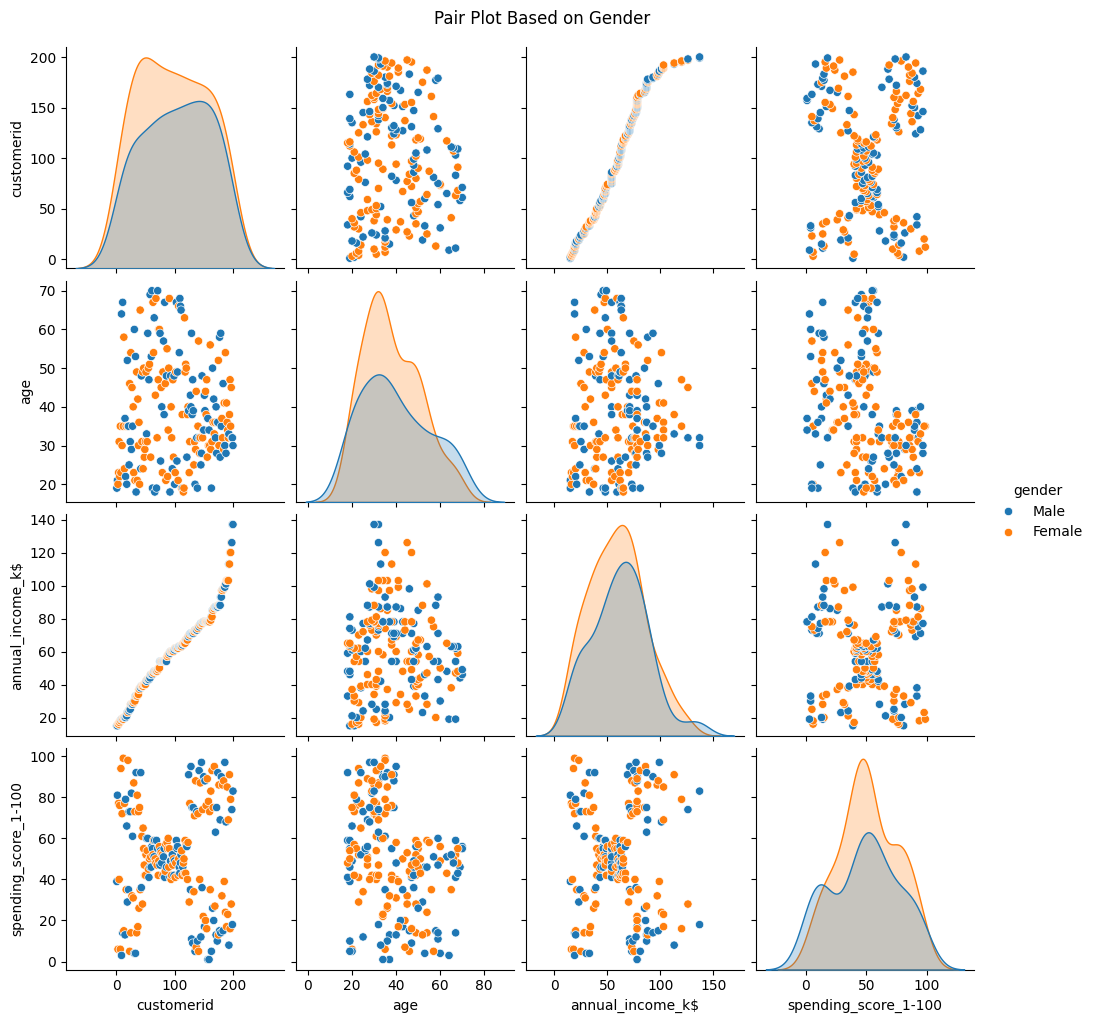

In [10]:
# make pairplot
sns.pairplot(customer_data,hue='gender')
plt.suptitle("Pair Plot Based on Gender", y=1.02)
plt.show()

#### Insight:
- based on the pairplots, we can see that both genders have similar characteristics for each analyzed numerical feature relationship.
- in other words, gender does not significantly influence age, annual income, or spending score for mall customers.
- we can confirm with Mann-Whitney U test.

In [11]:
# create function to separate group based on gender for each numerical feature
def whitney_tests(data):
    column_list = data.columns
    for column in column_list:
        # exclude gender
        if column != 'gender':
            male_group_data = data[data['gender']=='Male'][column]
            female_group_data = data[data['gender']=='Female'][column]

            # perform the Mann-Whitney U test
            statistic, p_value = stats.mannwhitneyu(male_group_data,female_group_data)

            # title
            print(f"Mann-Whitney U Test Result for Gender vs {column.capitalize()}")

            # Display the results
            print(f"U statistic: {statistic}, p-value: {p_value}")

            # Interpretation
            alpha = 0.05
            if p_value < alpha:
                print("The null hypothesis is rejected: There is a significant difference between groups.")
            else:
                print("Fail to reject the null hypothesis: There is no significant difference between groups.")
            print("")
        else:
            pass       

In [12]:
whitney_tests(customer_data)

Mann-Whitney U Test Result for Gender vs Customerid
U statistic: 5257.0, p-value: 0.4188053807494342
Fail to reject the null hypothesis: There is no significant difference between groups.

Mann-Whitney U Test Result for Gender vs Age
U statistic: 5127.5, p-value: 0.6241559040716951
Fail to reject the null hypothesis: There is no significant difference between groups.

Mann-Whitney U Test Result for Gender vs Annual_income_k$
U statistic: 5260.0, p-value: 0.41440053689269707
Fail to reject the null hypothesis: There is no significant difference between groups.

Mann-Whitney U Test Result for Gender vs Spending_score_1-100
U statistic: 4697.5, p-value: 0.5712794188160656
Fail to reject the null hypothesis: There is no significant difference between groups.



#### Insight:
- Mann-Whitney U Test proved that none of the variables have significant relationship with gender.
- We can experiment the inclusion effect of gender on clustering process.

### 5. Feature Engineering
**Let's create five experiments**:

 <u>Combine (1) and (2) to get 4 settings</u>:
1. Age as continuous vs categorical feature
- create age_group variable
2. With or without gender
- remove gender feature  

 <u>Control cluster</u>:  

3. Compare (1) and (2) with clustering of spending_score_1-100 and annual_income_k$

**Data preprocessing**: 
1. Standard Scaling
2. One-Hot Encoding

In [13]:
# before modification, let's create a copy dataset
# remove customerid and create age_group
modeling_data = customer_data.copy()
modeling_data = modeling_data.drop(columns=['customerid'])

# create bins for youngster, working population, mid-age, retired
bins=[0,20,40,60,100]
labels = ['youth', 'working_pop', 'mid_age', 'retired']  # Define the category labels

# Create the age_group column
modeling_data['age_group'] = pd.cut(modeling_data['age'], bins=bins, labels=labels, right=False)

modeling_data.head()

,gender,age,annual_income_k$,spending_score_1-100,age_group
0,Male,19,15,39,youth
1,Male,21,15,81,working_pop
2,Female,20,16,6,working_pop
3,Female,23,16,77,working_pop
4,Female,31,17,40,working_pop


In [14]:
# Create preprocessing function
def preprocess_func(df):
    # Get the column names in the list with select_dtypes
    numeric_features = df.select_dtypes(include='number').columns.tolist()
    cat_features = df.select_dtypes(include=['object','category']).columns.tolist()

    # Initialize transformers list
    transformers = [('num', StandardScaler(), numeric_features)]
    
    # Conditionally add the one-hot encoder if there are categorical features
    if cat_features:
        transformers.append(('cat', OneHotEncoder(drop='first', sparse_output=False), cat_features))
    
    # Create the ColumnTransformer
    preprocessor = ColumnTransformer(transformers)

    # Fit and transform the DataFrame
    X_transformed = preprocessor.fit_transform(df)

    # Get feature names for resulting DataFrame
    feature_names = numeric_features.copy()  # Start with numeric feature names

    # Retrieve OHE feature names if categorical features are present
    if cat_features:
        ohe_columns = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_features)
        feature_names += list(ohe_columns)  # Append OHE feature names

    # Create the DataFrame with the transformed data
    df_scaled_encoded = pd.DataFrame(X_transformed, columns=feature_names)

    return preprocessor, X_transformed, df_scaled_encoded

#### a. Experiment set 1
- age + with gender

In [15]:
# keep a separated dataset
set_1 = modeling_data.drop(columns=['age_group'])

# show result
set_1.head()

,gender,age,annual_income_k$,spending_score_1-100
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40


In [16]:
# get the results from function
preprocessor_1, X_transformed_1, transformed_df_1 = preprocess_func(set_1)

# show result
transformed_df_1.head()


,age,annual_income_k$,spending_score_1-100,gender_Male
0,-1.424569,-1.738999,-0.434801,1.0
1,-1.281035,-1.738999,1.195704,1.0
2,-1.352802,-1.700830,-1.715913,0.0
3,-1.137502,-1.700830,1.040418,0.0
4,-0.563369,-1.662660,-0.395980,0.0


In [17]:
# show others
print(preprocessor_1)
X_transformed_1

ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['age', 'annual_income_k$',
                                  'spending_score_1-100']),
                                ('cat',
                                 OneHotEncoder(drop='first',
                                               sparse_output=False),
                                 ['gender'])])


array([[-1.42456879, -1.73899919, -0.43480148,  1.        ],
       [-1.28103541, -1.73899919,  1.19570407,  1.        ],
       [-1.3528021 , -1.70082976, -1.71591298,  0.        ],
       [-1.13750203, -1.70082976,  1.04041783,  0.        ],
       [-0.56336851, -1.66266033, -0.39597992,  0.        ],
       [-1.20926872, -1.66266033,  1.00159627,  0.        ],
       [-0.27630176, -1.62449091, -1.71591298,  0.        ],
       [-1.13750203, -1.62449091,  1.70038436,  0.        ],
       [ 1.80493225, -1.58632148, -1.83237767,  1.        ],
       [-0.6351352 , -1.58632148,  0.84631002,  0.        ],
       [ 2.02023231, -1.58632148, -1.4053405 ,  1.        ],
       [-0.27630176, -1.58632148,  1.89449216,  0.        ],
       [ 1.37433211, -1.54815205, -1.36651894,  0.        ],
       [-1.06573534, -1.54815205,  1.04041783,  0.        ],
       [-0.13276838, -1.54815205, -1.44416206,  1.        ],
       [-1.20926872, -1.54815205,  1.11806095,  1.        ],
       [-0.27630176, -1.

#### b. Experiment set 2
- age + without gender

In [18]:
# keep a separated dataset
set_2 = modeling_data.drop(columns=['gender','age_group'])

# show result
set_2.head()

,age,annual_income_k$,spending_score_1-100
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


In [19]:
# get the results from function
preprocessor_2, X_transformed_2, transformed_df_2 = preprocess_func(set_2)

# show result
transformed_df_2.head()


,age,annual_income_k$,spending_score_1-100
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913
3,-1.137502,-1.700830,1.040418
4,-0.563369,-1.662660,-0.395980


#### c. Experiment set 3
- age_group + with gender

In [20]:
# keep a separated dataset
set_3 = modeling_data.drop(columns=['age'])

# show result
set_3.head()

,gender,annual_income_k$,spending_score_1-100,age_group
0,Male,15,39,youth
1,Male,15,81,working_pop
2,Female,16,6,working_pop
3,Female,16,77,working_pop
4,Female,17,40,working_pop


In [21]:
set_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   gender                200 non-null    object  
 1   annual_income_k$      200 non-null    int64   
 2   spending_score_1-100  200 non-null    int64   
 3   age_group             200 non-null    category
dtypes: category(1), int64(2), object(1)
memory usage: 5.2+ KB


In [22]:
# get the results from function
preprocessor_3, X_transformed_3, transformed_df_3 = preprocess_func(set_3)

# show result
transformed_df_3.head()


,annual_income_k$,spending_score_1-100,gender_Male,age_group_retired,age_group_working_pop,age_group_youth
0,-1.738999,-0.434801,1.0,0.0,0.0,1.0
1,-1.738999,1.195704,1.0,0.0,1.0,0.0
2,-1.700830,-1.715913,0.0,0.0,1.0,0.0
3,-1.700830,1.040418,0.0,0.0,1.0,0.0
4,-1.662660,-0.395980,0.0,0.0,1.0,0.0


#### d. Experiment set 4
- age_group + without gender

In [23]:
# keep a separated dataset
set_4 = modeling_data.drop(columns=['age','gender'])

# show result
set_4.head()

,annual_income_k$,spending_score_1-100,age_group
0,15,39,youth
1,15,81,working_pop
2,16,6,working_pop
3,16,77,working_pop
4,17,40,working_pop


In [24]:
# get the results from function
preprocessor_4, X_transformed_4, transformed_df_4 = preprocess_func(set_4)

# show result
transformed_df_4.head()


,annual_income_k$,spending_score_1-100,age_group_retired,age_group_working_pop,age_group_youth
0,-1.738999,-0.434801,0.0,0.0,1.0
1,-1.738999,1.195704,0.0,1.0,0.0
2,-1.700830,-1.715913,0.0,1.0,0.0
3,-1.700830,1.040418,0.0,1.0,0.0
4,-1.662660,-0.395980,0.0,1.0,0.0


#### 5. Experiment set 5 (Control)
- only spending score and annual income

In [25]:
# keep a separated dataset
set_5 = modeling_data.drop(columns=['age','gender','age_group'])

# show result
set_5.head()

,annual_income_k$,spending_score_1-100
0,15,39
1,15,81
2,16,6
3,16,77
4,17,40


In [26]:
# get the results from function
preprocessor_5, X_transformed_5, transformed_df_5 = preprocess_func(set_5)

# show result
transformed_df_5.head()


,annual_income_k$,spending_score_1-100
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913
3,-1.700830,1.040418
4,-1.662660,-0.395980


### 6. Modeling
**Clustering algorithm options**:  

  a. K-Means: simple and easy to interpret with assumption of spherical clusters. It works best with numeric dataset, but gender can be transformed with one-hot encoding. 
    
  b. DBScan: suitable when you expect clusters vary in sizes and shapes.  
   
  c. Gaussian Mixture Model: appropriate when features have different distributions. It's a probabilistic modeling approach.

#### a. Elbow Method for Optimum k Value
`metric`: within cluster sum of squares (WCSS)  
 
$$
\text{WCSS} = \sum_{i=1}^{k} \sum_{j=1}^{n_i} (x_{j}^{(i)} - \mu_i)^2
$$

Where:

- $( k )$ = number of clusters
- $( n_i )$ = number of points in cluster ( i )
- $( x_{j}^{(i)} )$ = data point ( j ) in cluster ( i )
- $( \mu_i )$ = centroid of cluster ( i )  

Smaller WCSS implies more dense and well-defined clusters.
We need to find the k value where WCSS change has significantly diminished.

##### Set 1

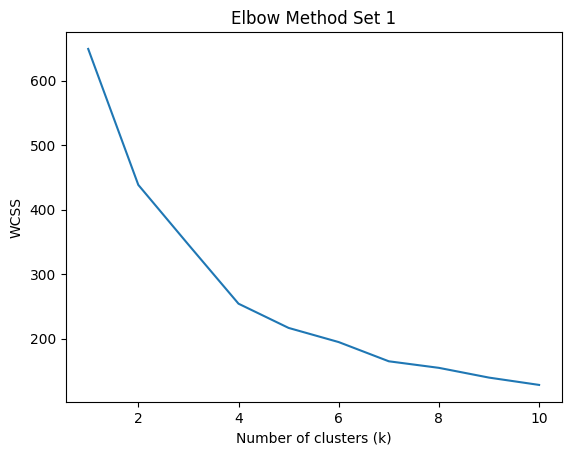

In [27]:
# Elbow Method for finding a suitable k value
wcss = []
for k in range(1, 11):  # Adjust range based on your needs
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(transformed_df_1)
    wcss.append(kmeans.inertia_)  # K-Means inertia is the WCSS

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method Set 1')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Insight**:
- The elbow point where WCSS does not reduce significantly when increasing k is 5.

##### Set 2

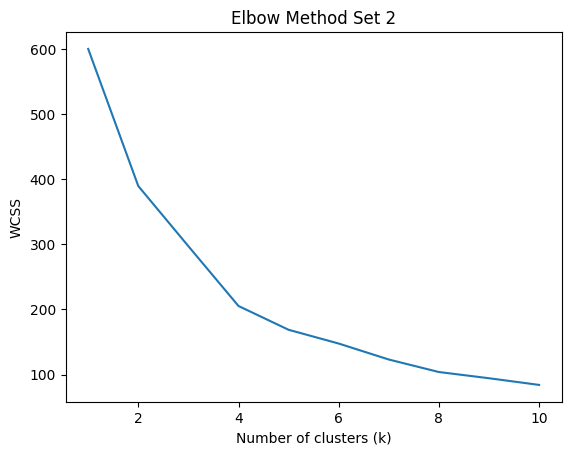

In [28]:
# Elbow Method for finding a suitable k value
wcss = []
for k in range(1, 11):  # Adjust range based on your needs
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(transformed_df_2)
    wcss.append(kmeans.inertia_)  # K-Means inertia is the WCSS

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method Set 2')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Insight**:
- The elbow point where WCSS does not reduce significantly when increasing k is 5.

##### Set 3

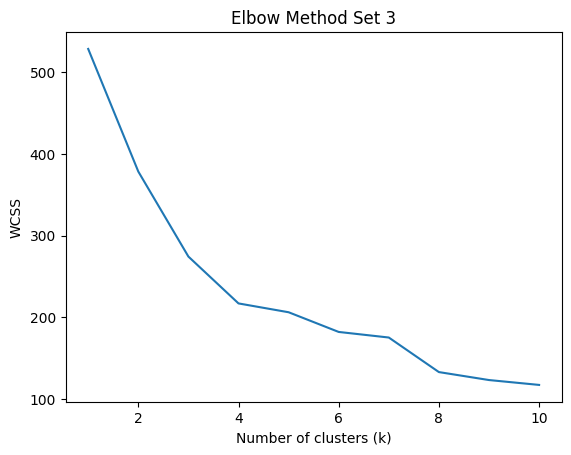

In [29]:
# Elbow Method for finding a suitable k value
wcss = []
for k in range(1, 11):  # Adjust range based on your needs
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(transformed_df_3)
    wcss.append(kmeans.inertia_)  # K-Means inertia is the WCSS

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method Set 3')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Insight**:
- The elbow point where WCSS does not reduce significantly when increasing k is 4.

##### Set 4

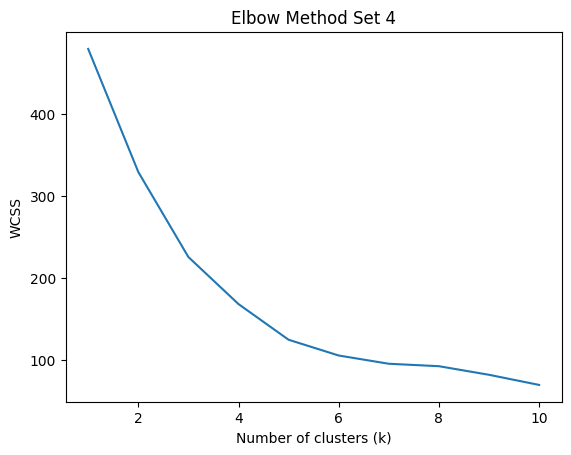

In [30]:
# Elbow Method for finding a suitable k value
wcss = []
for k in range(1, 11):  # Adjust range based on your needs
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(transformed_df_4)
    wcss.append(kmeans.inertia_)  # K-Means inertia is the WCSS

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method Set 4')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Insight**:
- The elbow point where WCSS does not reduce significantly when increasing k is 5.

##### Set 5

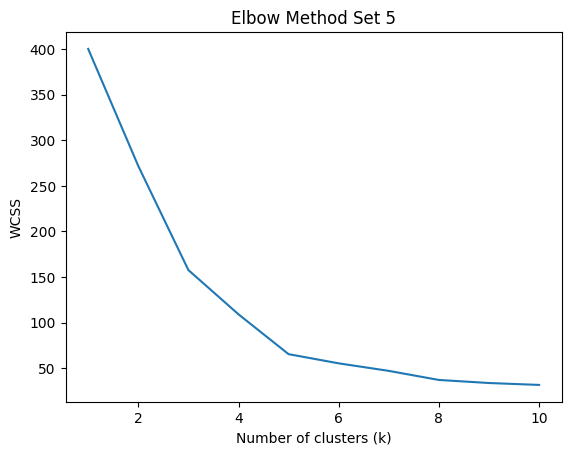

In [31]:
# Elbow Method for finding a suitable k value
wcss = []
for k in range(1, 11):  # Adjust range based on your needs
    kmeans = KMeans(n_clusters=k,random_state=10)
    kmeans.fit(transformed_df_5)
    wcss.append(kmeans.inertia_)  # K-Means inertia is the WCSS

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method Set 5')
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS')
plt.show()

**Insight**:
- The elbow point where WCSS does not reduce significantly when increasing k is 5.

#### b. Final Modeling Process

##### Set 1

**K-Means**

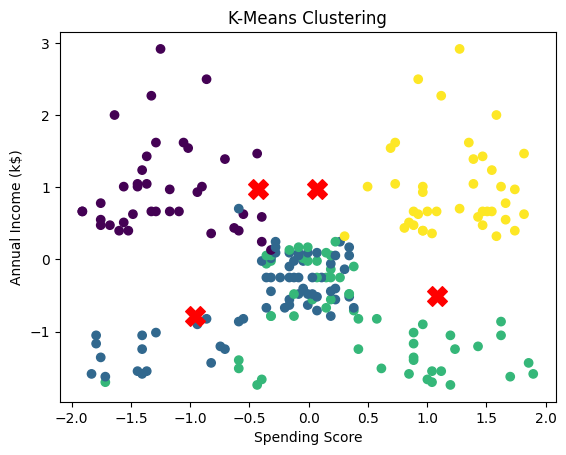

In [32]:
# model setup
kmeans_1 = KMeans(n_clusters=4,random_state=10)

# model fitting
kmeans_1.fit(transformed_df_1)

# predicted labels
kmeans_labels_1 = kmeans_1.labels_

# Plotting the results for K-Means
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=kmeans_labels_1, cmap='viridis')
plt.scatter(kmeans_1.cluster_centers_[:, 0], kmeans_1.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

**DBSCAN**

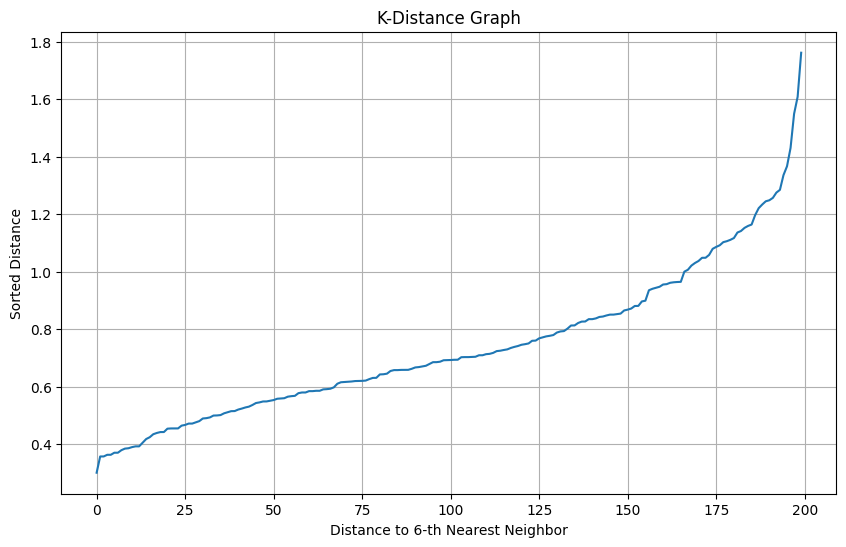

In [33]:
# to find suitable epsilon, let's use k-distance graph
k = 6
# Fit NearestNeighbors model
nbrs = NearestNeighbors(n_neighbors=k).fit(transformed_df_1)
distances, indices = nbrs.kneighbors(transformed_df_1)

# Get the distances to the k-th nearest neighbor
k_distance = distances[:, k-1]

# Sort the distances
k_distance_sorted = np.sort(k_distance)

# Create the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distance_sorted)
plt.title('K-Distance Graph')
plt.xlabel(f'Distance to {k}-th Nearest Neighbor')
plt.ylabel('Sorted Distance')
plt.grid(True)
plt.show()

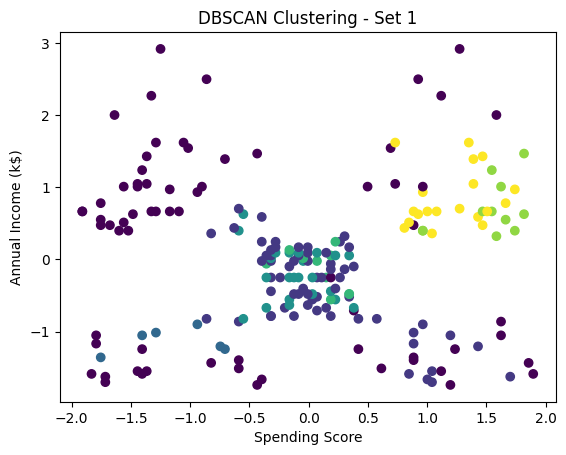

In [34]:
# model setup
dbscan_1 = DBSCAN(min_samples=7,eps=0.7)
dbscan_1.fit(transformed_df_1)

# label output
dbscan_labels_1 = dbscan_1.labels_

# Plotting the results for DBSCAN
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=dbscan_labels_1, cmap='viridis')
plt.title('DBSCAN Clustering - Set 1')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


**GMM**

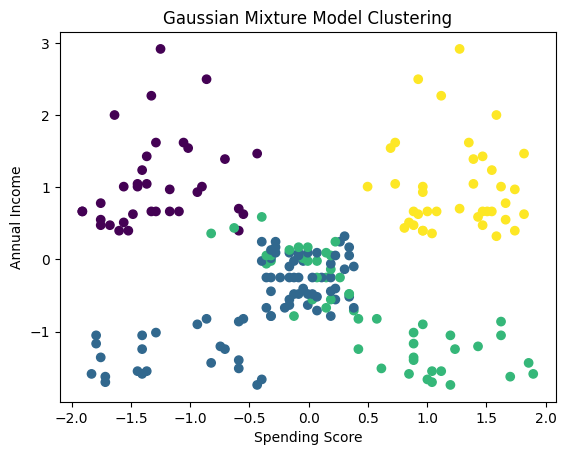

In [35]:
# GMM clustering
gmm_1 = GaussianMixture(n_components=4, random_state=10)
gmm_1.fit(transformed_df_1)

# Predictions
gmm_labels_1 = gmm_1.predict(transformed_df_1)

# Plotting the results for GMM
plt.scatter(transformed_df_1['spending_score_1-100'], transformed_df_1['annual_income_k$'], c=gmm_labels_1, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

##### Set 2

**KMeans**

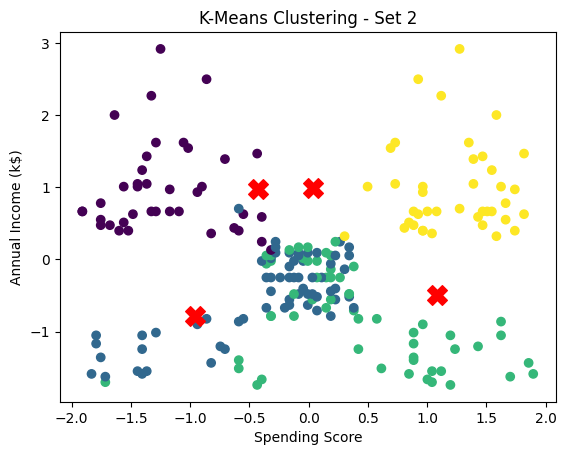

In [36]:
# model setup
kmeans_2 = KMeans(n_clusters=4,random_state=10)

# model fitting
kmeans_2.fit(transformed_df_2)

# predicted labels
kmeans_labels_2 = kmeans_1.labels_

# Plotting the results for K-Means
plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=kmeans_labels_2, cmap='viridis')
plt.scatter(kmeans_2.cluster_centers_[:, 0], kmeans_2.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

**DBSCAN**

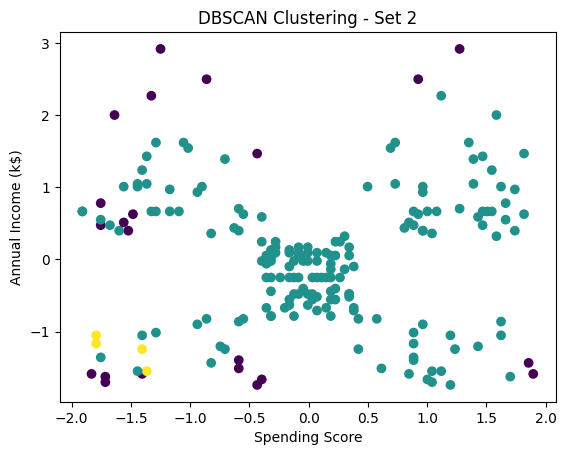

In [37]:
# model setup
dbscan_2 = DBSCAN(min_samples=7,eps=0.7)
dbscan_2.fit(transformed_df_2)

# label output
dbscan_labels_2 = dbscan_2.labels_

# Plotting the results for DBSCAN
plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=dbscan_labels_2, cmap='viridis')
plt.title('DBSCAN Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


**GMM**

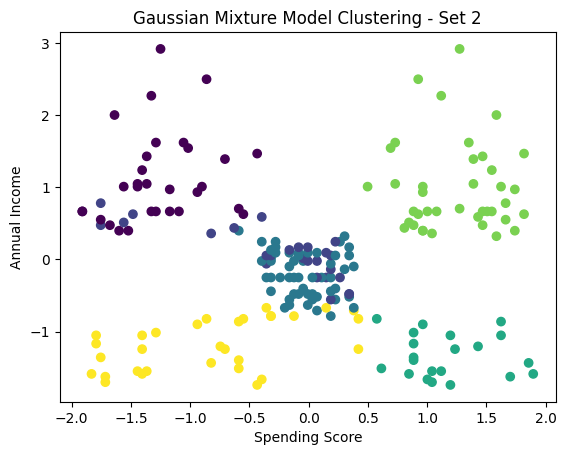

In [38]:
# GMM clustering
gmm_2 = GaussianMixture(n_components=6, random_state=10)
gmm_2.fit(transformed_df_2)

# Predictions
gmm_labels_2 = gmm_2.predict(transformed_df_2)

# Plotting the results for GMM
plt.scatter(transformed_df_2['spending_score_1-100'], transformed_df_2['annual_income_k$'], c=gmm_labels_2, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 2')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

##### Set 3

**K-Means**

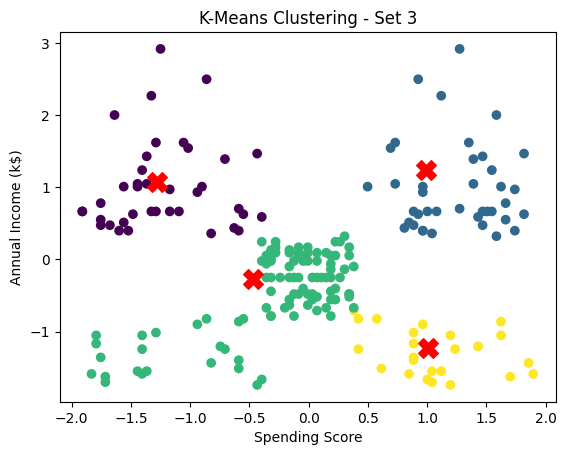

In [39]:
# model setup
kmeans_3 = KMeans(n_clusters=4,random_state=10)

# model fitting
kmeans_3.fit(transformed_df_3)

# predicted labels
kmeans_labels_3 = kmeans_3.labels_

# Plotting the results for K-Means
plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=kmeans_labels_3, cmap='viridis')
plt.scatter(kmeans_3.cluster_centers_[:, 0], kmeans_3.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

**DBSCAN**

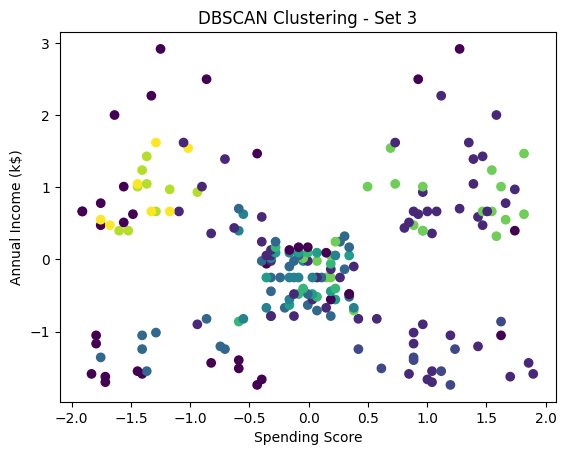

In [40]:
# model setup
dbscan_3 = DBSCAN(min_samples=7,eps=0.7)
dbscan_3.fit(transformed_df_3)

# label output
dbscan_labels_3 = dbscan_3.labels_

# Plotting the results for DBSCAN
plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=dbscan_labels_3, cmap='viridis')
plt.title('DBSCAN Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


**GMM**

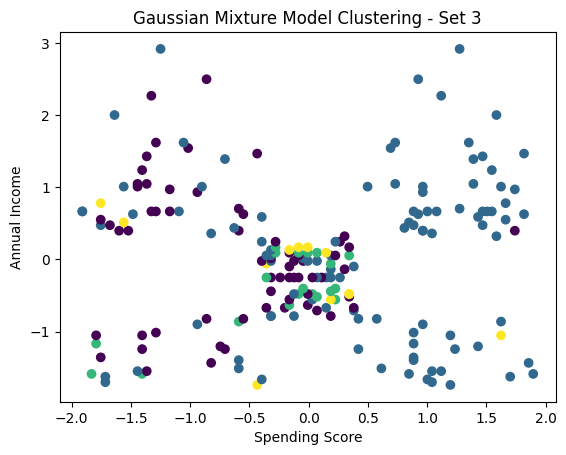

In [41]:
# GMM clustering
gmm_3 = GaussianMixture(n_components=4, random_state=10)
gmm_3.fit(transformed_df_3)

# Predictions
gmm_labels_3 = gmm_3.predict(transformed_df_3)

# Plotting the results for GMM
plt.scatter(transformed_df_3['spending_score_1-100'], transformed_df_3['annual_income_k$'], c=gmm_labels_3, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 3')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

##### Set 4

**K-Means**

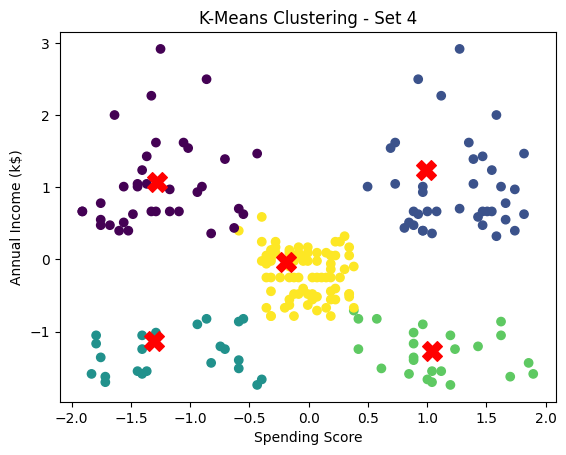

In [42]:
# model setup
kmeans_4 = KMeans(n_clusters=5,random_state=10)

# model fitting
kmeans_4.fit(transformed_df_4)

# predicted labels
kmeans_labels_4 = kmeans_4.labels_

# Plotting the results for K-Means
plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=kmeans_labels_4, cmap='viridis')
plt.scatter(kmeans_4.cluster_centers_[:, 0], kmeans_4.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

**DBSCAN**

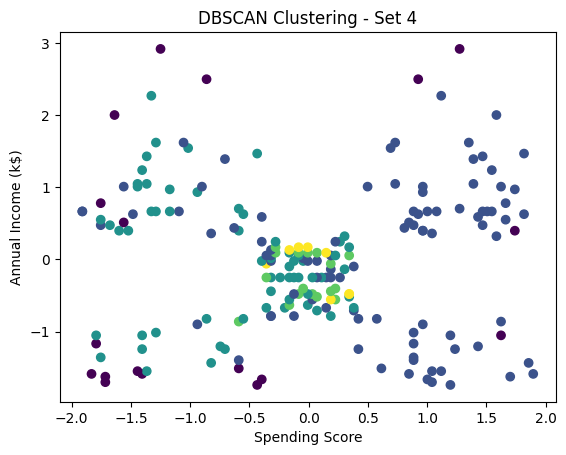

In [43]:
# model setup
dbscan_4 = DBSCAN(min_samples=7,eps=0.7)
dbscan_4.fit(transformed_df_4)

# label output
dbscan_labels_4 = dbscan_4.labels_

# Plotting the results for DBSCAN
plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=dbscan_labels_4, cmap='viridis')
plt.title('DBSCAN Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


**GMM**

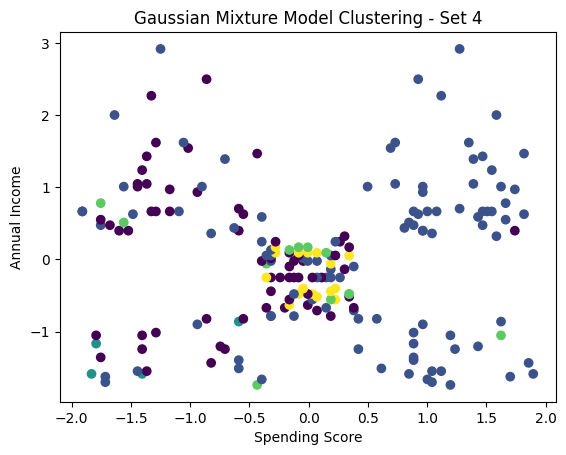

In [44]:
# GMM clustering
gmm_4 = GaussianMixture(n_components=5, random_state=10)
gmm_4.fit(transformed_df_4)

# Predictions
gmm_labels_4 = gmm_4.predict(transformed_df_4)

# Plotting the results for GMM
plt.scatter(transformed_df_4['spending_score_1-100'], transformed_df_4['annual_income_k$'], c=gmm_labels_4, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 4')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

##### Set 5

**K-Means**

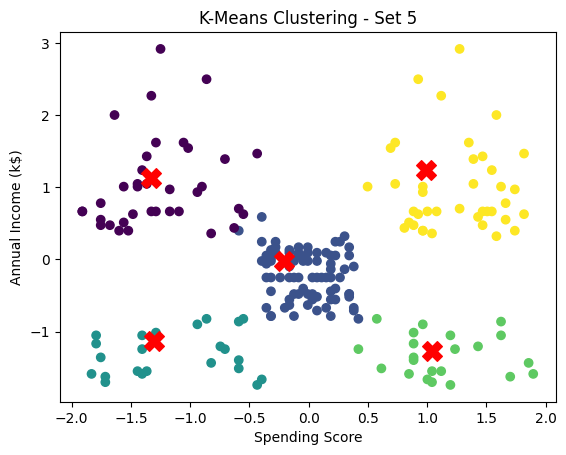

In [45]:
# model setup
kmeans_5 = KMeans(n_clusters=5,random_state=10)

# model fitting
kmeans_5.fit(transformed_df_5)

# predicted labels
kmeans_labels_5 = kmeans_5.labels_

# Plotting the results for K-Means
plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=kmeans_labels_5, cmap='viridis')
plt.scatter(kmeans_5.cluster_centers_[:, 0], kmeans_5.cluster_centers_[:, 1], s=200, c='red', marker='X')
plt.title('K-Means Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()

**DBSCAN**

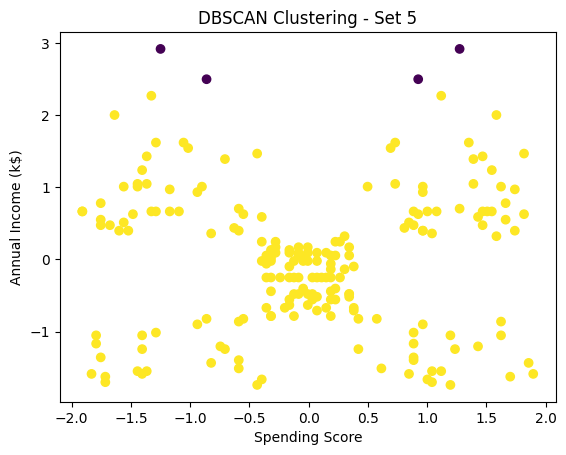

In [55]:
# model setup
dbscan_5 = DBSCAN(min_samples=7,eps=0.7)
dbscan_5.fit(transformed_df_5)

# label output
dbscan_labels_5 = dbscan_5.labels_

# Plotting the results for DBSCAN
plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=dbscan_labels_5, cmap='viridis')
plt.title('DBSCAN Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income (k$)')
plt.show()


**GMM**

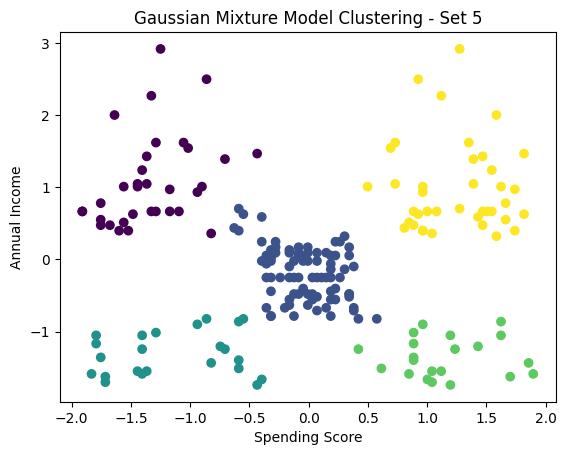

In [47]:
# GMM clustering
gmm_5 = GaussianMixture(n_components=5, random_state=10)
gmm_5.fit(transformed_df_5)

# Predictions
gmm_labels_5 = gmm_5.predict(transformed_df_5)

# Plotting the results for GMM
plt.scatter(transformed_df_5['spending_score_1-100'], transformed_df_5['annual_income_k$'], c=gmm_labels_5, cmap='viridis')
plt.title('Gaussian Mixture Model Clustering - Set 5')
plt.xlabel('Spending Score')
plt.ylabel('Annual Income')
plt.show()

### 7. Model Evaluation

**Evaluation metrics options**:  

 a. Silhouette Score: measures similarity of a point to its cluster compared to other clusters.  
 - The score range is from -1 to +1. Score near to +1 indicates points are well-clustered.  

 b. Davies-Bouldin Index: measures ratio of average intra-cluster distance to average inter-cluster distance. The smaller, the better the clustering since the separation is more apparent.  
  - <u>intra-cluster distance</u> shows how compact your cluster is (high internal similarity).  
  - <u>inter cluster distance</u> describes how different a cluster compared to another one (high external differentiation).

#### a. Silhouette Score Result

In [51]:
def calculate_silhouette_scores(datasets, labels_dict):
    """
    Calculate silhouette scores for multiple datasets and models.
    
    Parameters:
    datasets : dict
        A dictionary where keys are dataset names and values are the datasets (DataFrames).
    labels_dict : dict
        A dictionary where keys are model names and values are dictionaries mapping dataset names to cluster labels.
        
    Returns:
    pd.DataFrame : A DataFrame containing silhouette scores for each model and dataset.
    """
    results = {}

    # Iterate over datasets
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        # Iterate over each model type
        for model_name, model_labels in labels_dict.items():
            # Get the labels for the current dataset
            labels = model_labels.get(dataset_name)
            if labels is not None:
                # Calculate silhouette score
                if len(set(labels)) > 1:  # Ensure at least 2 clusters
                    score = silhouette_score(dataset, labels)
                else:
                    score = -1  # Not applicable for a single cluster
                
                results[dataset_name][model_name] = score
            else:
                results[dataset_name][model_name] = None

    # Create a DataFrame from the results
    silhouette_scores_df = pd.DataFrame(results)
    return silhouette_scores_df

In [50]:
# Datasets (replace these with your actual transformed datasets)
datasets = {
    'Dataset_1': transformed_df_1,
    'Dataset_2': transformed_df_2,
    'Dataset_3': transformed_df_3,
    'Dataset_4': transformed_df_4,
    'Dataset_5': transformed_df_5,
}

# Labels from models (replace these with your actual labels)
labels_dict = {
    'K-Means': {
        'Dataset_1': kmeans_labels_1,
        'Dataset_2': kmeans_labels_2,
        'Dataset_3': kmeans_labels_3,
        'Dataset_4': kmeans_labels_4,
        'Dataset_5': kmeans_labels_5,
    },
    'DBSCAN': {
        'Dataset_1': dbscan_labels_1,
        'Dataset_2': dbscan_labels_2,
        'Dataset_3': dbscan_labels_3,
        'Dataset_4': dbscan_labels_4,
        'Dataset_5': dbscan_labels_5,
    },
    'GMM': {
        'Dataset_1': gmm_labels_1,
        'Dataset_2': gmm_labels_2,
        'Dataset_3': gmm_labels_3,
        'Dataset_4': gmm_labels_4,
        'Dataset_5': gmm_labels_5,
    }
}

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5
K-Means,0.350441,0.404161,0.339103,0.435224,0.553942
DBSCAN,0.024478,0.109941,0.091601,0.149171,0.424827
GMM,0.326546,0.392619,0.134160,0.115279,0.553689


In [52]:
# Calling the function to get the silhouette scores table
silhouette_scores_table = calculate_silhouette_scores(datasets, labels_dict)

# Display the resulting DataFrame
silhouette_scores_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5
K-Means,0.350441,0.404161,0.339103,0.435224,0.553942
DBSCAN,0.024478,0.109941,0.091601,0.149171,0.424827
GMM,0.326546,0.392619,0.134160,0.115279,0.553689


#### b. Davies-Bouldin-Index Result

In [53]:
def calculate_davies_bouldin_indices(datasets, labels_dict):
    """
    Calculate the Davies-Bouldin Index for multiple datasets and models.
    
    Parameters:
    datasets : dict
        A dictionary where keys are dataset names and values are the datasets (DataFrames).
    labels_dict : dict
        A dictionary where keys are model names and values are dictionaries mapping dataset names to cluster labels.
        
    Returns:
    pd.DataFrame : A DataFrame containing Davies-Bouldin Index for each model and dataset.
    """
    results = {}

    # Iterate over datasets
    for dataset_name, dataset in datasets.items():
        results[dataset_name] = {}
        # Iterate over each model type
        for model_name, model_labels in labels_dict.items():
            # Get the labels for the current dataset
            labels = model_labels.get(dataset_name)
            if labels is not None:
                # Calculate Davies-Bouldin Index
                if len(set(labels)) > 1:  # Ensure at least 2 clusters
                    db_index = davies_bouldin_score(dataset, labels)
                else:
                    db_index = float('inf')  # Not applicable for a single cluster
                
                results[dataset_name][model_name] = db_index
            else:
                results[dataset_name][model_name] = None

    # Create a DataFrame from the results
    db_index_df = pd.DataFrame(results)
    return db_index_df

In [54]:
# Calling the function to get the silhouette scores table
db_index_table = calculate_davies_bouldin_indices(datasets, labels_dict)

# Display the resulting DataFrame
db_index_table

,Dataset_1,Dataset_2,Dataset_3,Dataset_4,Dataset_5
K-Means,1.069270,0.934533,1.073872,0.884750,0.570808
DBSCAN,1.898050,3.080161,1.892971,3.558216,0.816827
GMM,1.128705,0.954088,1.806840,1.397435,0.576010


#### Insight:
In analyzing the results for K-Means, DBSCAN, and Gaussian Mixture Model (GMM) across five experiments, we observe significant differences in clustering performance as indicated by the silhouette scores and Davies-Bouldin Index values. Below are the key insights derived from these tables:

**Silhouette Scores**:

K-Means performed best with a silhouette score of 0.553942 in Dataset_5, indicating well-defined clusters. However, this dataset has a limited feature set.

Dataset_4 produced respectable K-Means performance with a silhouette score of 0.435224.

**Davies-Bouldin Index**:

The Davies-Bouldin Index for K-Means in Dataset_4 is 0.884750, which suggests a relatively better-defined cluster structure compared to other datasets, except compared to Dataset_5 with a score of 0.570808. 

However, Dataset_4 includes more informative features such as age group, spending score, and annual income. This richer feature set allows for a more comprehensive understanding of the characteristics defining the clusters.

In contrast, Dataset_5 only uses spending score and annual income that lack depth and actionable insights, even if they present better clustering performance metrics.

Therefore, K-Means model from dataset 4 is selected as the best option for clustering algorithm.


### 7. Post-Modeling EDA
`aim`: to characterize the clustering result.

### 8. Conclusion